In [1]:
import os
import shutil
import random
import zipfile
import numpy as np
from PIL import Image, UnidentifiedImageError
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to filter valid images and ignore unwanted files like Thumbs.db
def get_valid(file_path):
    correct_files = []
    unwanted_files = ['Thumbs.db']  # List of known unwanted files

    for name in os.listdir(file_path):
        # Skip unwanted files
        if name in unwanted_files:
            print(f"Skipping unwanted file: {name}")
            continue
        
        try:
            img = Image.open(os.path.join(file_path, name))
            img.verify()  # Ensure image integrity
            correct_files.append(name)
        except UnidentifiedImageError:
            print(f"Invalid image: {name}")  # Information about invalid file
        except Exception as e:
            print(f"Error opening file {name}: {str(e)}")
    
    return correct_files

# Paths to the ZIP file and extraction folder
zip_file_path = r'C:/Users/DELL/Downloads/kagglecatsanddogs_5340.zip'
extract_to_path = r'C:/Users/DELL/Downloads/cats-and-dogs'

# Extracting the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("File extracted!")

# Define paths to image directories
classes = ['Cat', 'Dog']
original_cat_path = os.path.join(extract_to_path, 'PetImages/Cat')
original_dog_path = os.path.join(extract_to_path, 'PetImages/Dog')

# Get valid images
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)

# Check if valid images were found
if len(original_cat) == 0 or len(original_dog) == 0:
    raise ValueError("No valid images found in one or both categories!")

# Shuffle the images
random.seed(101)
random.shuffle(original_cat)
random.shuffle(original_dog)

# Set sizes for training, validation, and testing datasets
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

# Create main directory for datasets
base_directory = 'dataset'
os.makedirs(base_directory, exist_ok=True)  # Use makedirs with exist_ok=True to avoid FileExistsError
type_datasets = ['train', 'valid', 'test']
directories = {}

# Create directories for training, validation, and test sets
for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.makedirs(directory, exist_ok=True)  # Avoid error if directory already exists
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.makedirs(animal, exist_ok=True)  # Avoid error if directory already exists
        directories[f'{type_dataset}_{name_class}'] = animal + '/'

# Copy files into the corresponding directories
index = 0
for name_cat, name_dog in zip(original_cat, original_dog):
    if index < train_size:
        type_of_dataset = 'train'
    elif train_size <= index < (train_size + valid_size):
        type_of_dataset = 'valid'
    else:
        type_of_dataset = 'test'

    # Copy cat images
    try:
        shutil.copyfile(src=os.path.join(original_cat_path, name_cat),
                        dst=os.path.join(directories[f'{type_of_dataset}_Cat'], name_cat))
    except Exception as e:
        print(f"Error copying cat image {name_cat}: {str(e)}")

    # Copy dog images
    try:
        shutil.copyfile(src=os.path.join(original_dog_path, name_dog),
                        dst=os.path.join(directories[f'{type_of_dataset}_Dog'], name_dog))
    except Exception as e:
        print(f"Error copying dog image {name_dog}: {str(e)}")

    index += 1

# Print the number of files in each set
print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')


File extracted!
Invalid image: 666.jpg
Skipping unwanted file: Thumbs.db
Invalid image: 11702.jpg


C:\Users\DELL\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping unwanted file: Thumbs.db
Dog - train: 8749	Cat - train: 8749
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1251	Cat - test:  1251


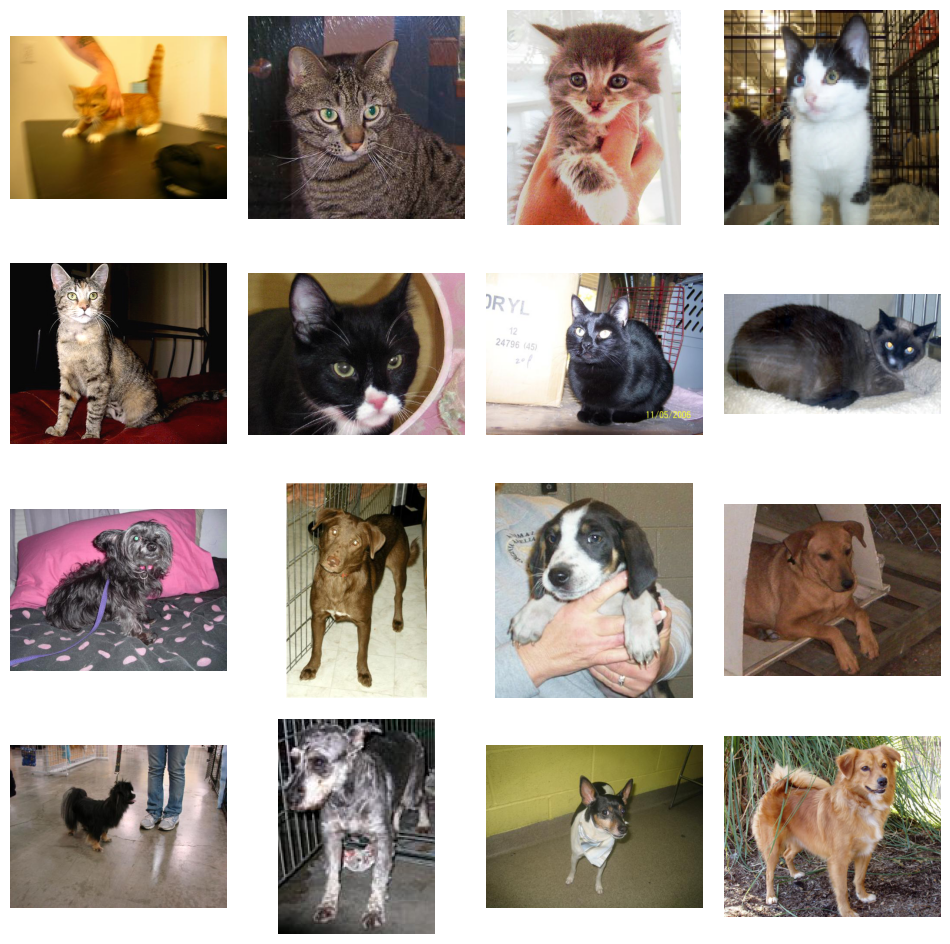

In [2]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Display 8 cat images in the first two rows (positions 1 to 8)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"] + element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Display 8 dog images in the last two rows (positions 9 to 16)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"] + element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


In [3]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17498 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17498 images belonging to 2 classes.


In [4]:
import os

# Initialize list for models
models = []

# Check if the 'history' directory exists, if not, create it
if not os.path.exists("history"):
    os.mkdir("history")
else:
    print("'history' directory already exists.")

# Check if the 'charts' directory exists, if not, create it
if not os.path.exists("charts"):
    os.mkdir("charts")
else:
    print("'charts' directory already exists.")


'history' directory already exists.
'charts' directory already exists.


In [5]:
from keras.layers import Input

model_baseline = Sequential()
model_baseline.add(Input(shape=(150, 150, 3)))  # Explicit input layer
model_baseline.add(Flatten())
model_baseline.add(Dense(units=1, activation='sigmoid'))

model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])

model_baseline.summary()
models.append(model_baseline)  # Store the actual model in the list


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          67,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [7]:
history_baseline = model_baseline.fit(train_generator,  # Use fit instead of fit_generator
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es])

# Convert history to a DataFrame
history_baseline_df = pd.DataFrame(history_baseline.history)

# Save the DataFrame to a CSV file
history_baseline_csv_file = r'C:\Kodilla\history\history_baseline.csv'
history_baseline_df.to_csv(history_baseline_csv_file, index=False)


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.4993 - loss: 1.1105 - val_accuracy: 0.5056 - val_loss: 0.8358
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5079 - loss: 0.9463 - val_accuracy: 0.4864 - val_loss: 1.1219
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 1.0328 - val_accuracy: 0.5000 - val_loss: 1.1368
Epoch 4/1000


C:\Users\DELL\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5317 - loss: 0.9199 - val_accuracy: 0.5369 - val_loss: 0.7500
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.5282 - loss: 0.9183 - val_accuracy: 0.5020 - val_loss: 0.9007
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.5388 - loss: 0.9048 - val_accuracy: 0.8333 - val_loss: 0.4983
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 84s 620ms/step - accuracy: 0.5136 - loss: 0.9269 - val_accuracy: 0.5168 - val_loss: 0.8584
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 592ms/step - accuracy: 0.5274 - loss: 0.9245 - val_accuracy: 0.5240 - val_loss: 0.8123
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 1.0314 - val_accuracy: 0.3333 - val_loss: 1.6320
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - accuracy: 0.5230 - loss: 0.9293 - val_accuracy: 0.5469 - val_loss: 0.7391
Epoch 11/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.5393 - loss: 0.89

In [8]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 54760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          54,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history_simple_1 = model_simple_1.fit(train_generator,  # Use fit instead of fit_generator
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es])

# Convert history to a DataFrame
history_simple_1_df = pd.DataFrame(history_simple_1.history)

# Save the history to the corrected file path
history_simple_1_csv_file = r'C:\Kodilla\history\history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 268ms/step - accuracy: 0.5410 - loss: 0.8993 - val_accuracy: 0.6350 - val_loss: 0.6273
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 36s 265ms/step - accuracy: 0.6537 - loss: 0.6109 - val_accuracy: 0.6735 - val_loss: 0.6040
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.7111 - loss: 0.5731 - val_accuracy: 0.8333 - val_loss: 0.4735
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.7134 - loss: 0.5574 - val_accuracy: 0.7099 - val_loss: 0.5702
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.7476 - loss: 0.5155 - val_accuracy: 0.7248 - val_loss: 0.5439


In [10]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56250)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          56,251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_simple_2 = model_simple_2.fit(train_generator,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es])

# Convert the history to a DataFrame
history_simple_2_df = pd.DataFrame(history_simple_2.history)

# Save the history to a CSV file in the specified folder
history_simple_2_csv_file = r'C:\Kodilla\history\history_simple_2.csv'
history_simple_2_df.to_csv(history_simple_2_csv_file, index=False)


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.5593 - loss: 0.8318 - val_accuracy: 0.6819 - val_loss: 0.5972
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 591ms/step - accuracy: 0.6894 - loss: 0.5844 - val_accuracy: 0.7143 - val_loss: 0.5711
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7111 - loss: 0.5558 - val_accuracy: 1.0000 - val_loss: 0.4241
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 100s 734ms/step - accuracy: 0.7444 - loss: 0.5232 - val_accuracy: 0.7264 - val_loss: 0.5391
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 96s 708ms/step - accuracy: 0.7734 - loss: 0.4886 - val_accuracy: 0.7192 - val_loss: 0.5390
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8201 - loss: 0.4429 - val_accuracy: 0.8333 - val_loss: 0.3989
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 123s 904ms/step - accuracy: 0.7784 - loss: 0.4738 - val_accuracy: 0.7380 - val_loss: 0.5259
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.8029

In [12]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

# Compilation with the corrected 'learning_rate' argument
model_1.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),  # Corrected the argument name
                metrics=['accuracy'])

model_1.summary()
models.append("model_1")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_model_1 = model_1.fit(train_generator_augmentation,  # Use fit instead of fit_generator
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es])

# Convert history to a DataFrame
history_model_1_df = pd.DataFrame(history_model_1.history)

# Save the history DataFrame to a CSV file
history_model_1_csv_file = r'C:\Kodilla\history\history_model_1.csv'
history_model_1_df.to_csv(history_model_1_csv_file, index=False)


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 753s 5s/step - accuracy: 0.5108 - loss: 0.6921 - val_accuracy: 0.5769 - val_loss: 0.6781
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 732s 5s/step - accuracy: 0.5599 - loss: 0.6786 - val_accuracy: 0.6414 - val_loss: 0.6317
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6873 - loss: 0.6258 - val_accuracy: 0.6667 - val_loss: 0.6575
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 712s 5s/step - accuracy: 0.6171 - loss: 0.6467 - val_accuracy: 0.6635 - val_loss: 0.6049
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.6468 - loss: 0.6194 - val_accuracy: 0.6711 - val_loss: 0.5988


In [14]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))

# Compilation with corrected 'learning_rate' argument
model_2.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),  # Corrected the argument name
                metrics=['accuracy'])

model_2.summary()
models.append("model_2")



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_model_2 = model_2.fit(train_generator_augmentation,  # Use fit instead of fit_generator
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es])

# Convert history to a DataFrame
history_model_2_df = pd.DataFrame(history_model_2.history)

# Save the history DataFrame to a CSV file
history_model_2_csv_file = r'C:\Kodilla\history\history_model_2.csv'
history_model_2_df.to_csv(history_model_2_csv_file, index=False)


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 819s 6s/step - accuracy: 0.5032 - loss: 0.6930 - val_accuracy: 0.5120 - val_loss: 0.6903
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 748s 6s/step - accuracy: 0.5136 - loss: 0.6909 - val_accuracy: 0.5317 - val_loss: 0.6761
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 61s 430ms/step - accuracy: 0.5238 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.7095
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 763s 6s/step - accuracy: 0.5848 - loss: 0.6758 - val_accuracy: 0.6230 - val_loss: 0.6455
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 799s 6s/step - accuracy: 0.5987 - loss: 0.6612 - val_accuracy: 0.6138 - val_loss: 0.6460


In [16]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))

# Compilation with corrected 'learning_rate' argument
model_3.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),  # Corrected the argument name
                metrics=['accuracy'])

model_3.summary()
models.append("model_3")



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_model_3 = model_3.fit(train_generator_augmentation,  # Use fit instead of fit_generator
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es])

# Convert history to a DataFrame
history_model_3_df = pd.DataFrame(history_model_3.history)

# Save the history DataFrame to a CSV file
history_model_3_csv_file = r'C:\Kodilla\history\history_model_3.csv'
history_model_3_df.to_csv(history_model_3_csv_file, index=False)


Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 785s 5s/step - accuracy: 0.5034 - loss: 0.6931 - val_accuracy: 0.5236 - val_loss: 0.6892
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.5358 - loss: 0.6865 - val_accuracy: 0.5909 - val_loss: 0.6605
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.6014 - loss: 0.6580 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 762s 5s/step - accuracy: 0.5957 - loss: 0.6640 - val_accuracy: 0.6046 - val_loss: 0.6551
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 778s 6s/step - accuracy: 0.6055 - loss: 0.6525 - val_accuracy: 0.6174 - val_loss: 0.6408


In [18]:
import os
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

# Fine-tuning: freeze all layers up to 'block5_conv1'
set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Print the trainable status of each layer
for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

# Build the new model on top of the VGG16 base
model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))

# Compile the model with the corrected optimizer argument
model_4.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),  # Corrected argument
                metrics=['accuracy'])

# Display the model architecture
model_4.summary()

# Ensure the models list is initialized
models = []
models.append("model_4")

# Assuming you have defined train_generator_augmentation, steps_per_epoch, epochs, validation_generator, validation_steps, es earlier
# Fit the model (replace fit_generator with fit)
history_model_4 = model_4.fit(
    train_generator_augmentation,  # Make sure this is defined
    steps_per_epoch=steps_per_epoch,  # Define these variables as per your data
    epochs=epochs,
    validation_data=validation_generator,  # Make sure this is defined
    validation_steps=validation_steps,  # Define this variable
    callbacks=[es]  # Assuming es is an EarlyStopping callback or similar
)

# Convert history to a DataFrame
history_model_4_df = pd.DataFrame(history_model_4.history)

# Determine the correct file path based on the operating system
if os.name == 'nt':  # If running on Windows
    history_model_4_csv_file = r'C:\Kodilla\history\history_model_4.csv'
else:  # For Linux/MacOS
    history_model_4_csv_file = r'/home/user/Kodilla/history/history_model_4.csv'

# Save the history DataFrame to a CSV file
history_model_4_df.to_csv(history_model_4_csv_file, index=False)



layer_name: input_layer_6 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 3341s 24s/step - accuracy: 0.6977 - loss: 0.5604 - val_accuracy: 0.8201 - val_loss: 0.3292
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 3256s 24s/step - accuracy: 0.8810 - loss: 0.2758 - val_accuracy: 0.9403 - val_loss: 0.1556
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.9453 - loss: 0.1641 - val_accuracy: 1.0000 - val_loss: 0.0490
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2979s 22s/step - accuracy: 0.9000 - loss: 0.2542 - val_accuracy: 0.9419 - val_loss: 0.1532
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2653s 20s/step - accuracy: 0.9213 - loss: 0.1906 - val_accuracy: 0.9515 - val_loss: 0.1264


Loading history for model: history_model_1


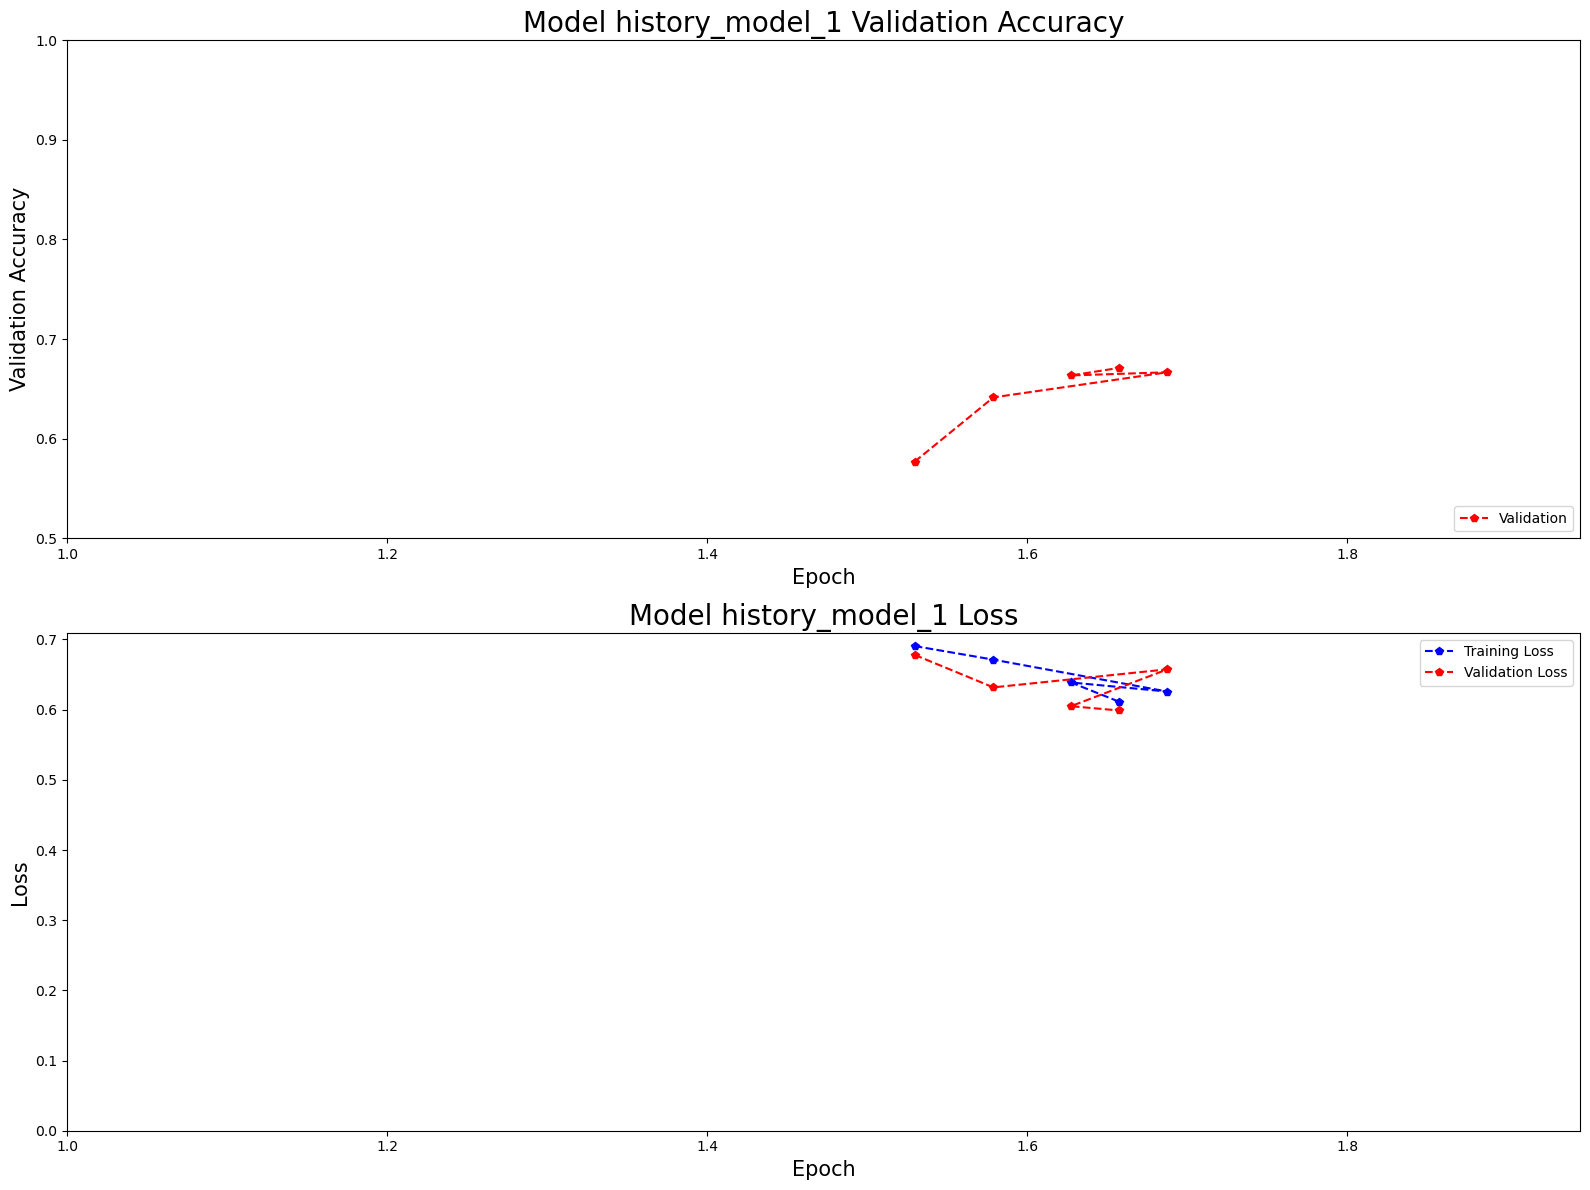

Loading history for model: history_model_2


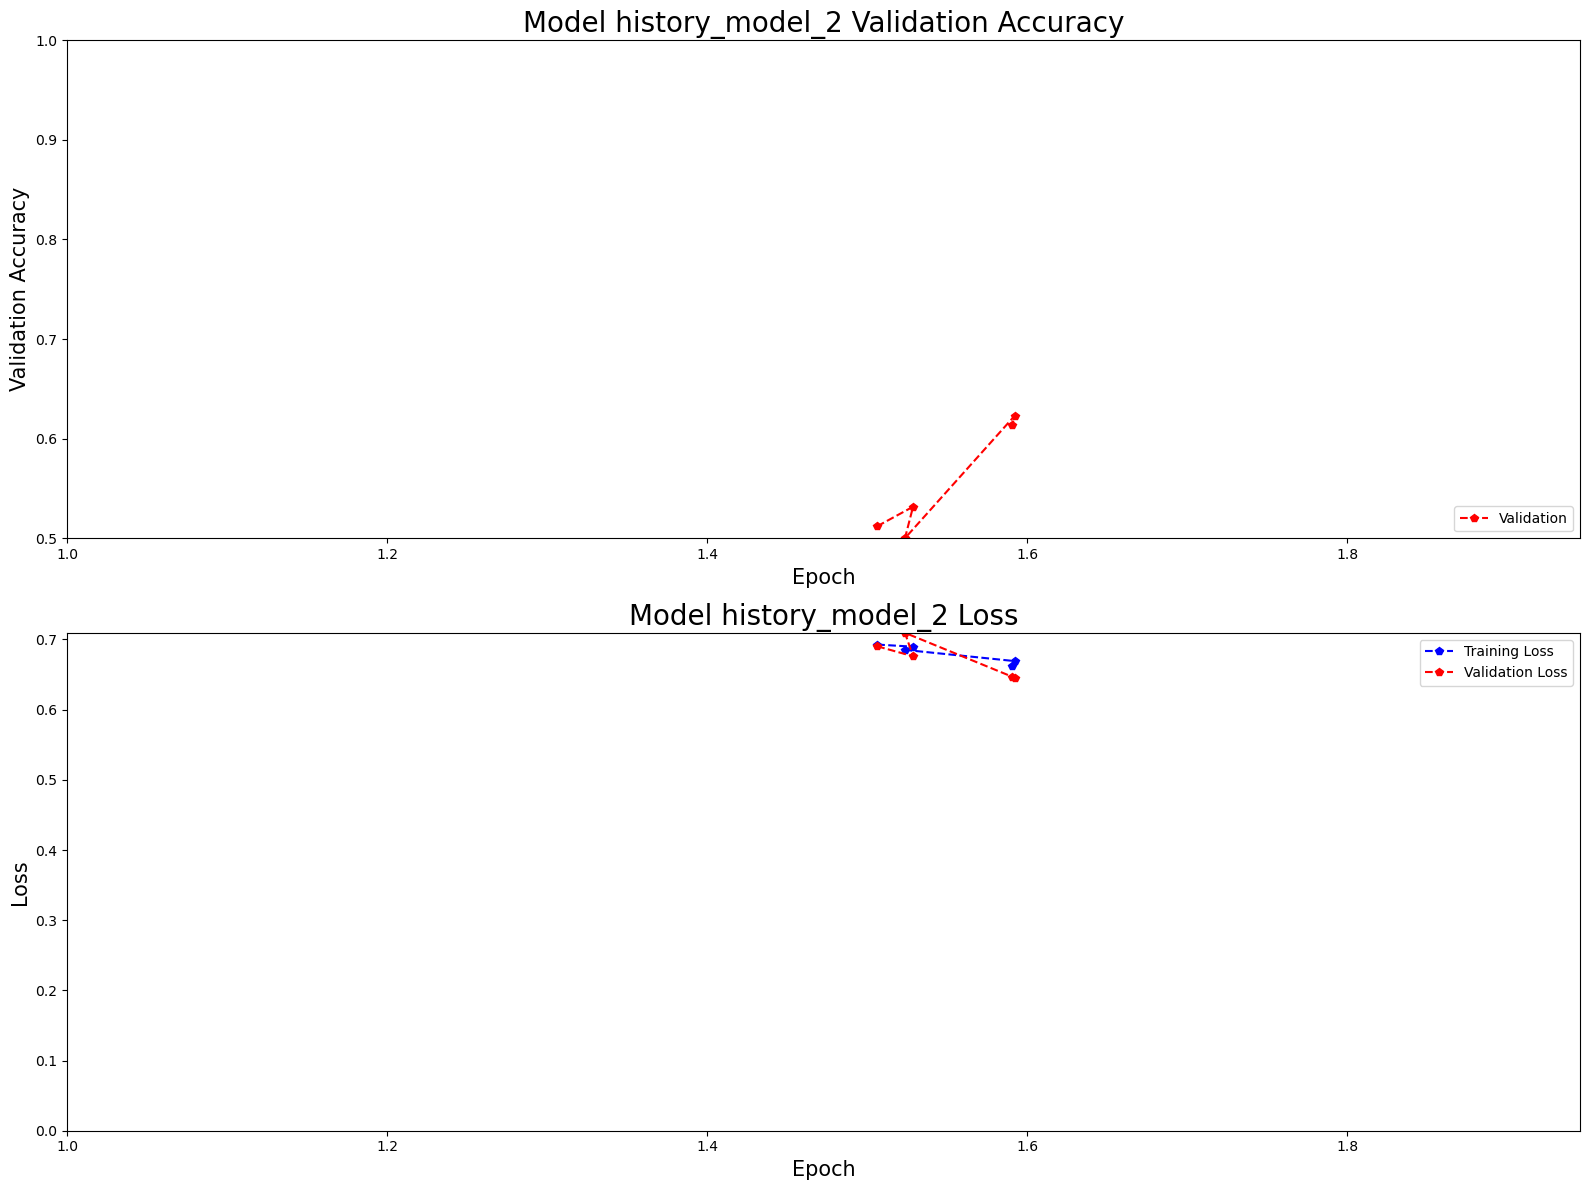

Loading history for model: history_model_3


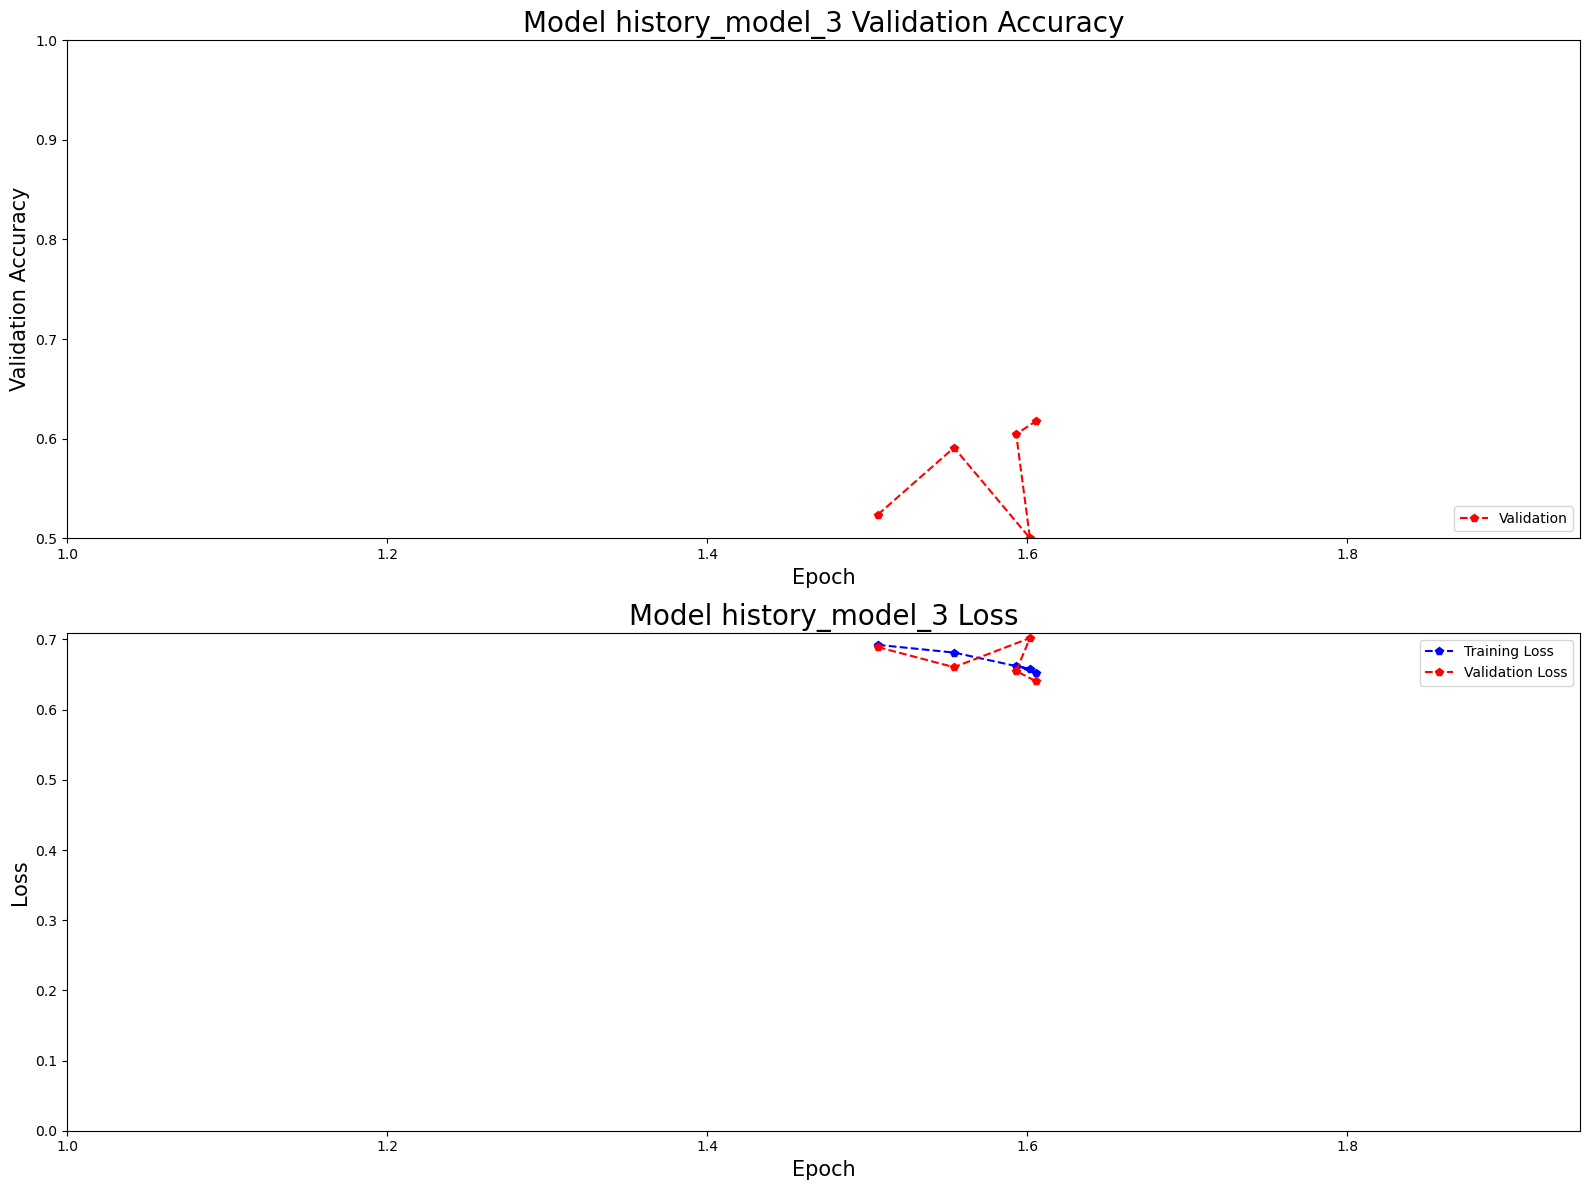

Loading history for model: history_model_4


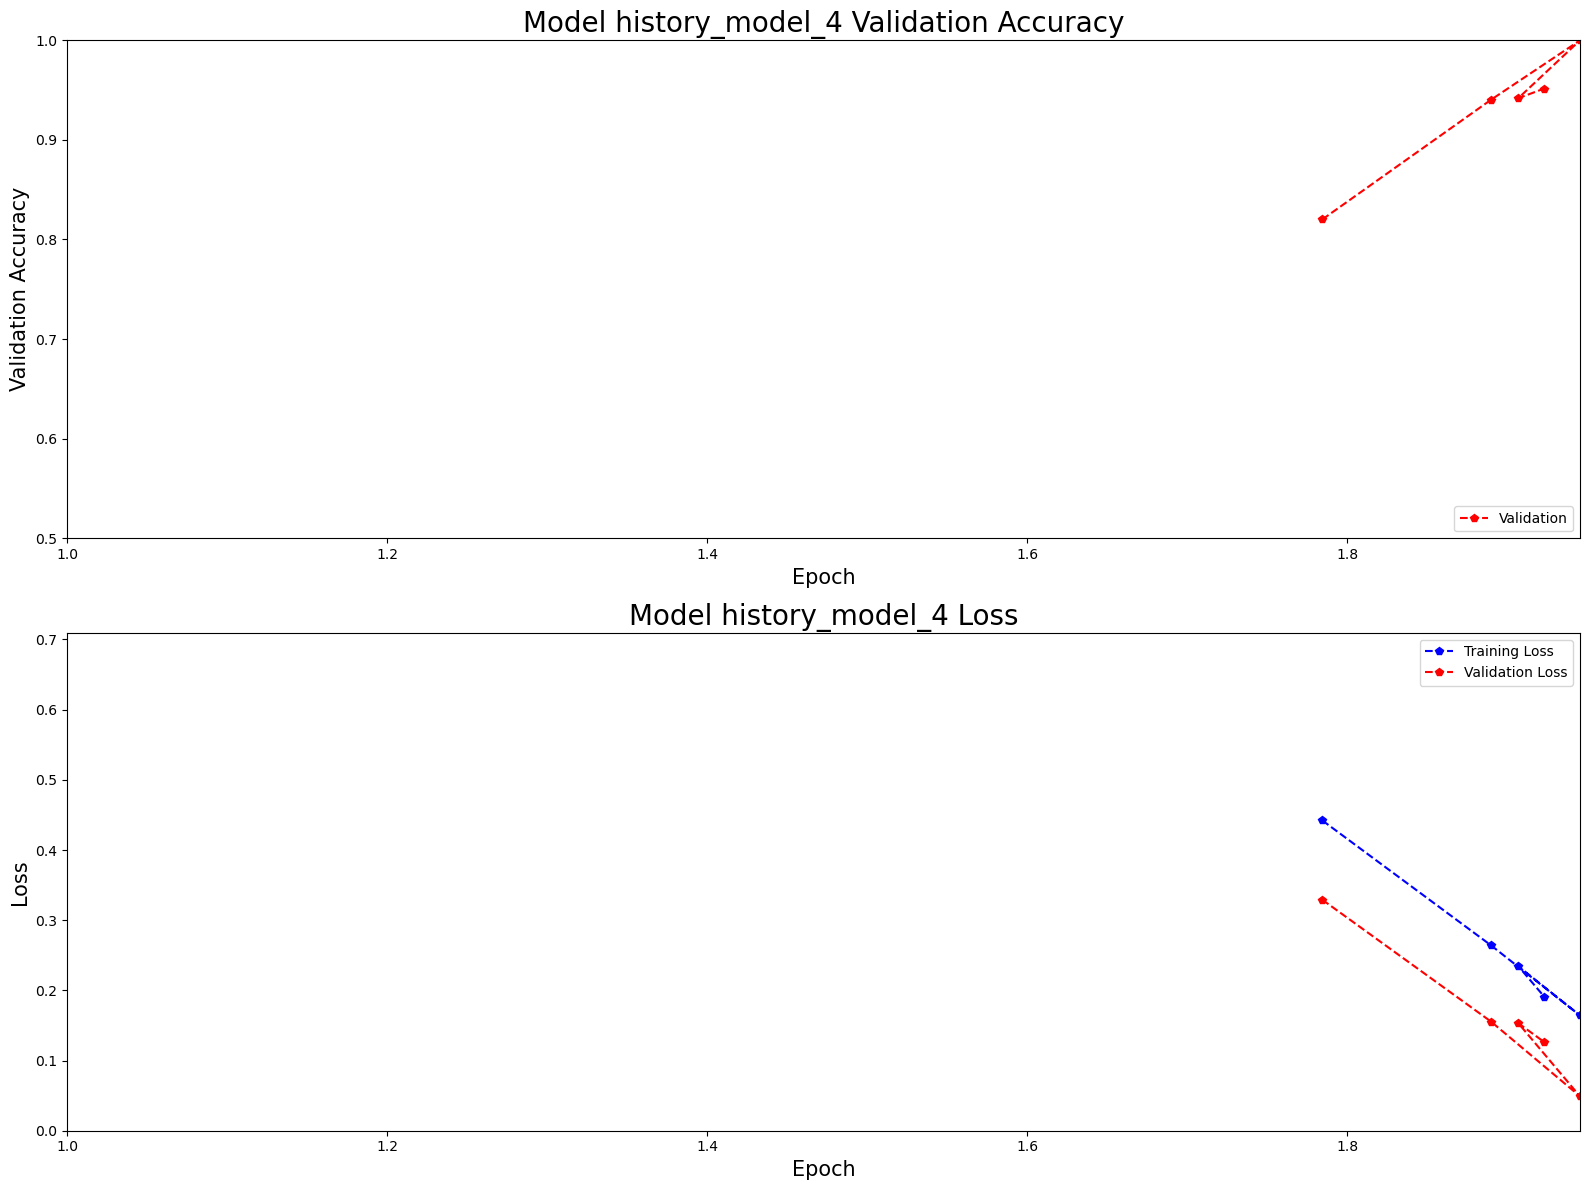

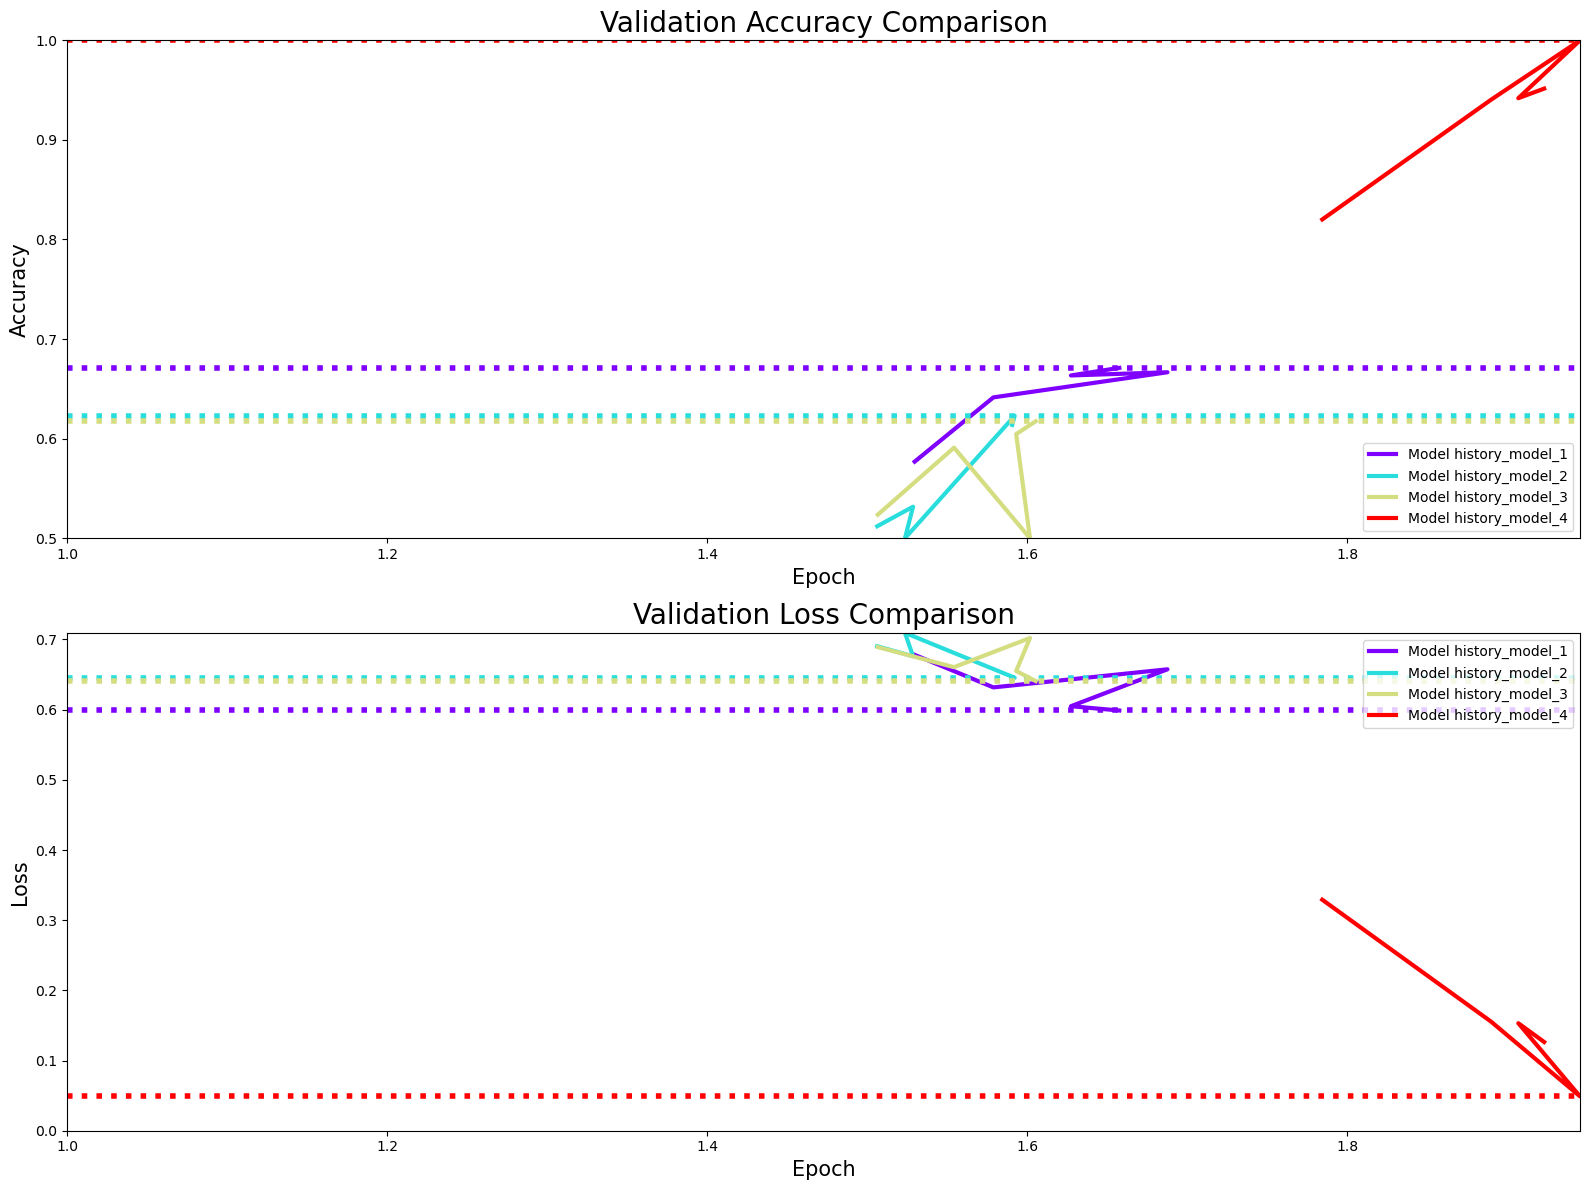

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Example model names corresponding to your models (replace with actual model names)
model_names = ['history_model_1', 'history_model_2', 'history_model_3', 'history_model_4']  # Replace with actual model names

# Initialize variables
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(model_names)))

# Create charts directory if it doesn't exist
if not os.path.exists('charts'):
    os.makedirs('charts')

# Iterate through models and compute min and max values for accuracy and loss
for model_name in model_names:
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    # Update max index and min/max for loss/accuracy based on available columns
    if 'val_accuracy' in df.columns:
        max_index = max(max_index, max(df.index))
        min_accuracy = min(min_accuracy, df['val_accuracy'].min())
    if 'loss' in df.columns and 'val_loss' in df.columns:
        max_loss = max(max_loss, df[['loss', 'val_loss']].max().max())

# Plot the results for each model
for model_name in model_names:
    print(f'Loading history for model: {model_name}')
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(211)

    # Only plot validation accuracy if it exists
    if 'val_accuracy' in df.columns:
        ax.plot(df['val_accuracy'], "rp--")
        ax.set_title(f'Model {model_name} Validation Accuracy', fontsize=20)
        ax.set_ylabel('Validation Accuracy', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([min_accuracy, 1])

    plt.legend(['Validation'], loc='lower right')

    ax = fig.add_subplot(212)

    # Plot loss if available
    if 'loss' in df.columns and 'val_loss' in df.columns:
        ax.plot(df['loss'], "bp--")
        ax.plot(df['val_loss'], "rp--")
        ax.set_title(f'Model {model_name} Loss', fontsize=20)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([0, max_loss])
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    else:
        print(f"Loss columns not found for {model_name}")

    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model_name}.png', transparent=True, dpi=600)
    plt.show()

# Plot all models' validation accuracy and loss together
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(211)

for model_name, color in zip(model_names, colors):
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    # Plot validation accuracy if available
    if 'val_accuracy' in df.columns:
        ax.plot(df['val_accuracy'], label=f'Model {model_name}', color=color, linewidth=3)
        ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Validation Accuracy Comparison', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
plt.legend(loc='lower right')

ax = fig.add_subplot(212)
for model_name, color in zip(model_names, colors):
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    # Plot validation loss if available
    if 'val_loss' in df.columns:
        ax.plot(df['val_loss'], label=f'Model {model_name}', color=color, linewidth=3)
        ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Validation Loss Comparison', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()



New Model

In [20]:
from keras.regularizers import l2

# New Model with Additional Convolutional Layers and Regularization
model_5 = Sequential()

# Block 1
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3 (Newly added)
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4 (Newly added)
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers with Regularization
model_5.add(Flatten())
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # L2 Regularization added
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 Regularization added
model_5.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])

# Model Summary
model_5.summary()

# Add the new model to the list of models
models.append("model_5")

# Train the new model
history_model_5 = model_5.fit(train_generator_augmentation,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es])

# Save the training history of model_5
history_model_5_df = pd.DataFrame(history_model_5.history)
history_model_5_csv_file = r'C:\Kodilla\history\history_model_5.csv'
with open(history_model_5_csv_file, mode='w') as f:
    history_model_5_df.to_csv(f)


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 852s 6s/step - accuracy: 0.5088 - loss: 6.0389 - val_accuracy: 0.4880 - val_loss: 3.2931
Epoch 2/1000
  9/136 ━━━━━━━━━━━━━━━━━━━━ 7:58 4s/step - accuracy: 0.5354 - loss: 3.2564

C:\Users\DELL\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 718s 5s/step - accuracy: 0.5220 - loss: 2.8211 - val_accuracy: 0.5228 - val_loss: 1.8384
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.4883 - loss: 1.8375

C:\Users\DELL\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4921 - loss: 1.8364 - val_accuracy: 0.5000 - val_loss: 1.8392
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 810s 6s/step - accuracy: 0.5583 - loss: 1.6637 - val_accuracy: 0.5954 - val_loss: 1.2892
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 611s 5s/step - accuracy: 0.5774 - loss: 1.2196 - val_accuracy: 0.6222 - val_loss: 1.0237


In [21]:
from keras.layers import BatchNormalization

# Model with more convolutional layers and batch normalization
model_6 = Sequential()

# Block 1
model_6.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_6.add(BatchNormalization())
model_6.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_6.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_6.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_6.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers with Dropout
model_6.add(Flatten())
model_6.add(Dropout(0.5))
model_6.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Dropout(0.5))
model_6.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])

# Model Summary
model_6.summary()

# Add model to the list
models.append("model_6")

# Train the model
history_model_6 = model_6.fit(train_generator_augmentation,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es])

# Save the training history of model_6
history_model_6_df = pd.DataFrame(history_model_6.history)
history_model_6_csv_file = r'C:\Kodilla\history\history_model_6.csv'
with open(history_model_6_csv_file, mode='w') as f:
    history_model_6_df.to_csv(f)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,515,873 (24.86 MB)

 Trainable params: 6,514,913 (24.85 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1596s 11s/step - accuracy: 0.5431 - loss: 7.2243 - val_accuracy: 0.4964 - val_loss: 5.0915
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1486s 11s/step - accuracy: 0.6377 - loss: 4.4034 - val_accuracy: 0.5052 - val_loss: 3.4420
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.6956 - loss: 2.9782 - val_accuracy: 0.5000 - val_loss: 3.3670
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1542s 11s/step - accuracy: 0.6684 - loss: 2.7388 - val_accuracy: 0.5585 - val_loss: 2.2134
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1530s 11s/step - accuracy: 0.7096 - loss: 1.9271 - val_accuracy: 0.6282 - val_loss: 1.6640


In [22]:
# Model with fewer filters but deeper architecture with regularization
model_7 = Sequential()

# Block 1
model_7.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_7.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers with Regularization
model_7.add(Flatten())
model_7.add(Dropout(0.5))
model_7.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_7.add(Dropout(0.5))
model_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_7.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])

# Model Summary
model_7.summary()

# Add model to the list
models.append("model_7")

# Train the model
history_model_7 = model_7.fit(train_generator_augmentation,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es])

# Save the training history of model_7
history_model_7_df = pd.DataFrame(history_model_7.history)
history_model_7_csv_file = r'C:\Kodilla\history\history_model_7.csv'
with open(history_model_7_csv_file, mode='w') as f:
    history_model_7_df.to_csv(f)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 37, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 37, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 762,577 (2.91 MB)

 Trainable params: 762,577 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 801s 6s/step - accuracy: 0.5077 - loss: 3.4755 - val_accuracy: 0.5621 - val_loss: 2.2656
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 912s 7s/step - accuracy: 0.5207 - loss: 2.0222 - val_accuracy: 0.5248 - val_loss: 1.4818
Epoch 3/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4925 - loss: 1.4816 - val_accuracy: 0.8333 - val_loss: 1.4610
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1380s 10s/step - accuracy: 0.5345 - loss: 1.3770 - val_accuracy: 0.5801 - val_loss: 1.1504
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 1704s 13s/step - accuracy: 0.5595 - loss: 1.1105 - val_accuracy: 0.5497 - val_loss: 1.0042


Loading history for model: history_model_1


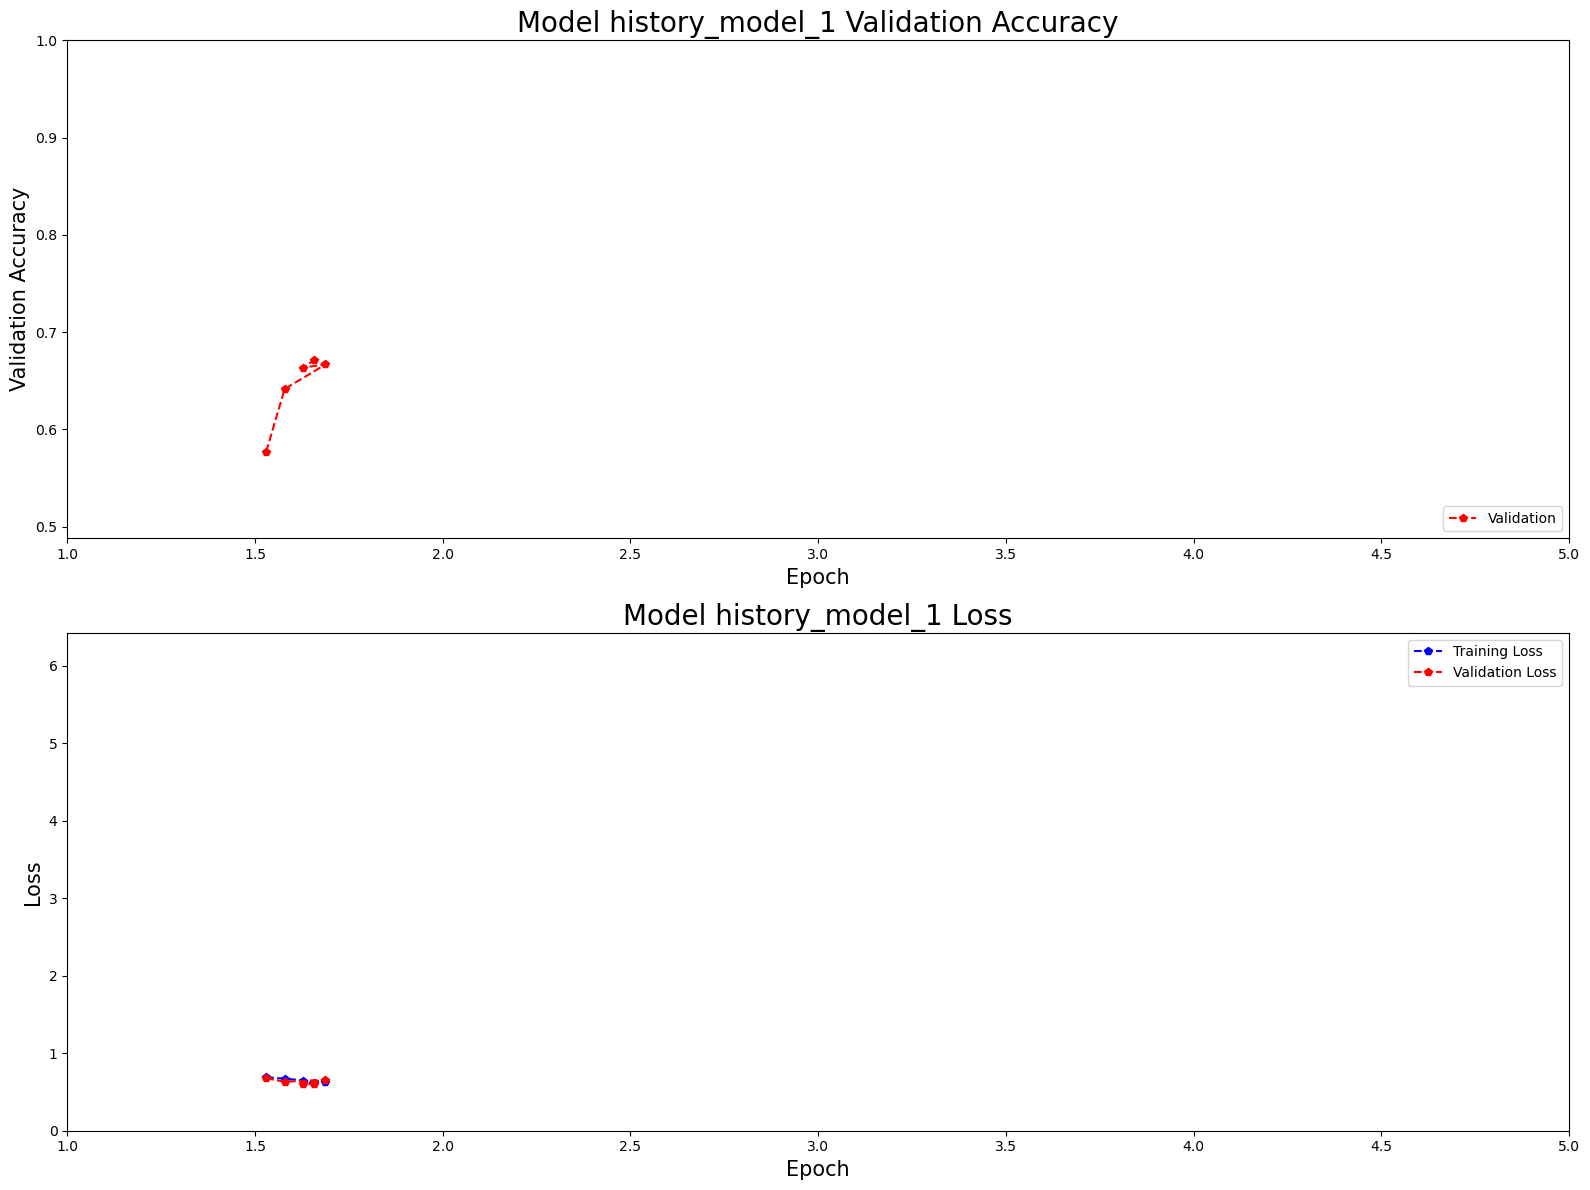

Loading history for model: history_model_2


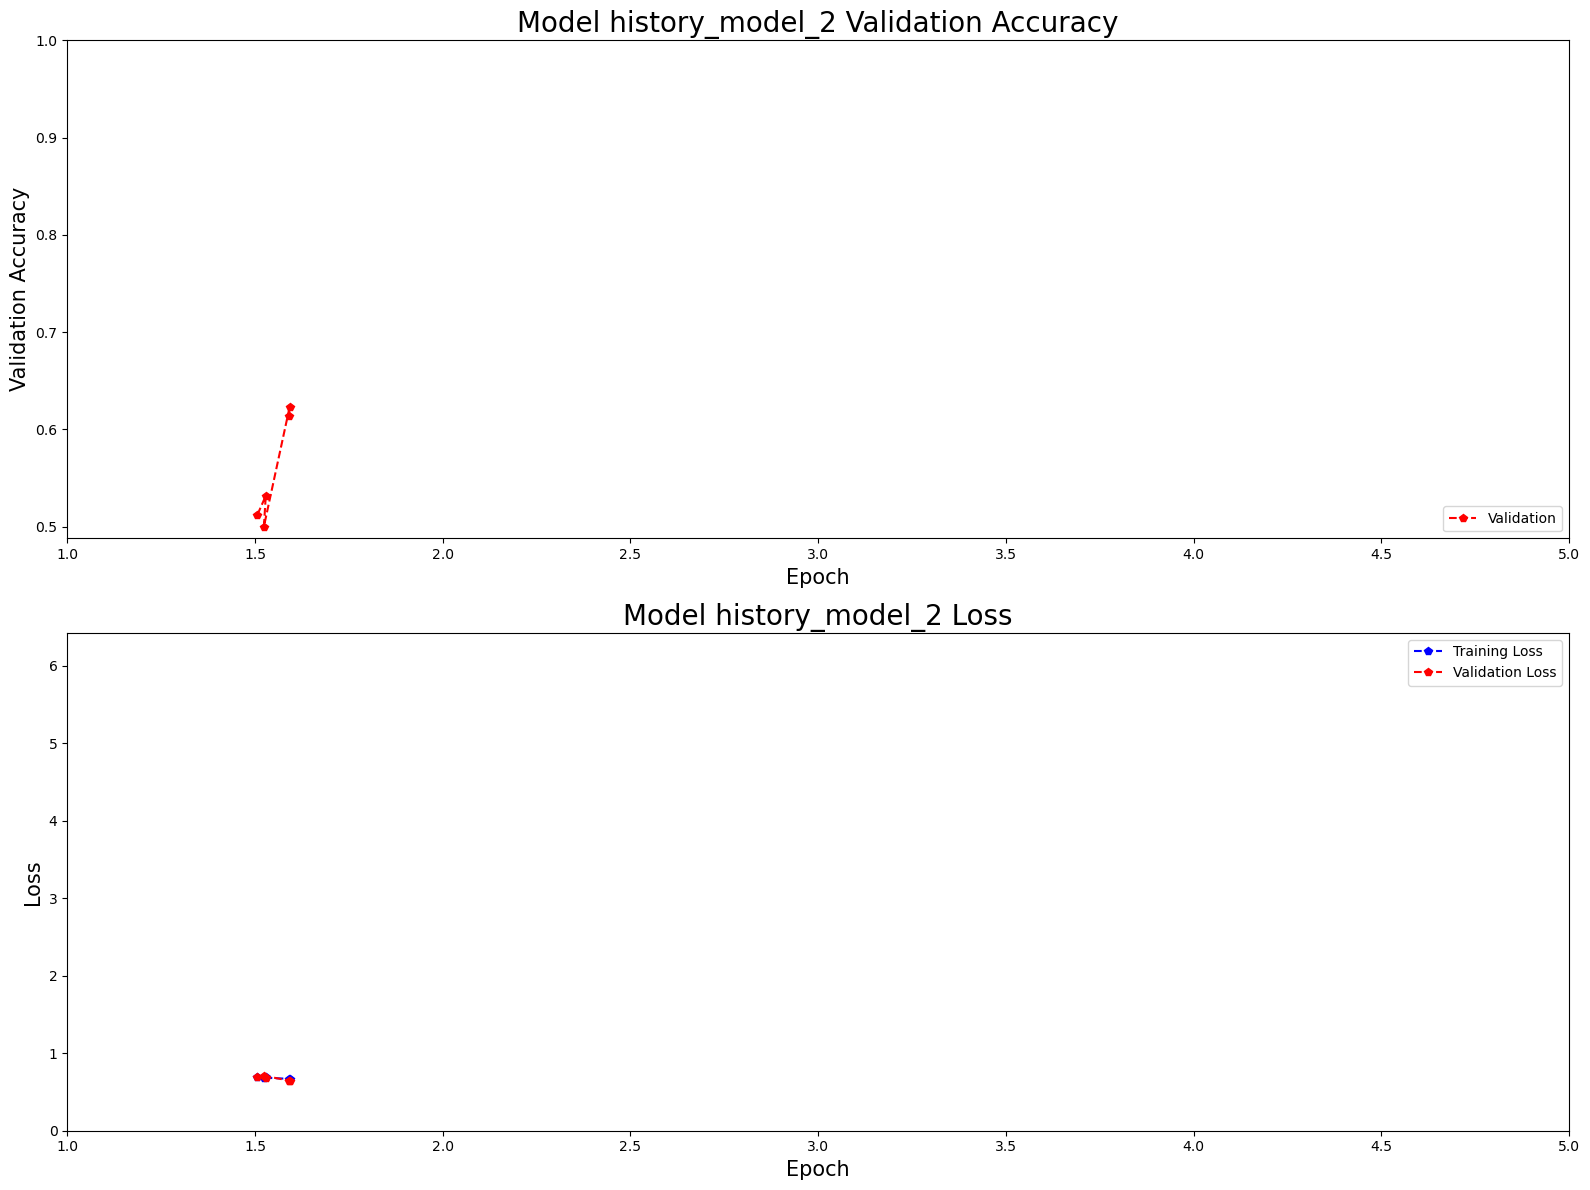

Loading history for model: history_model_3


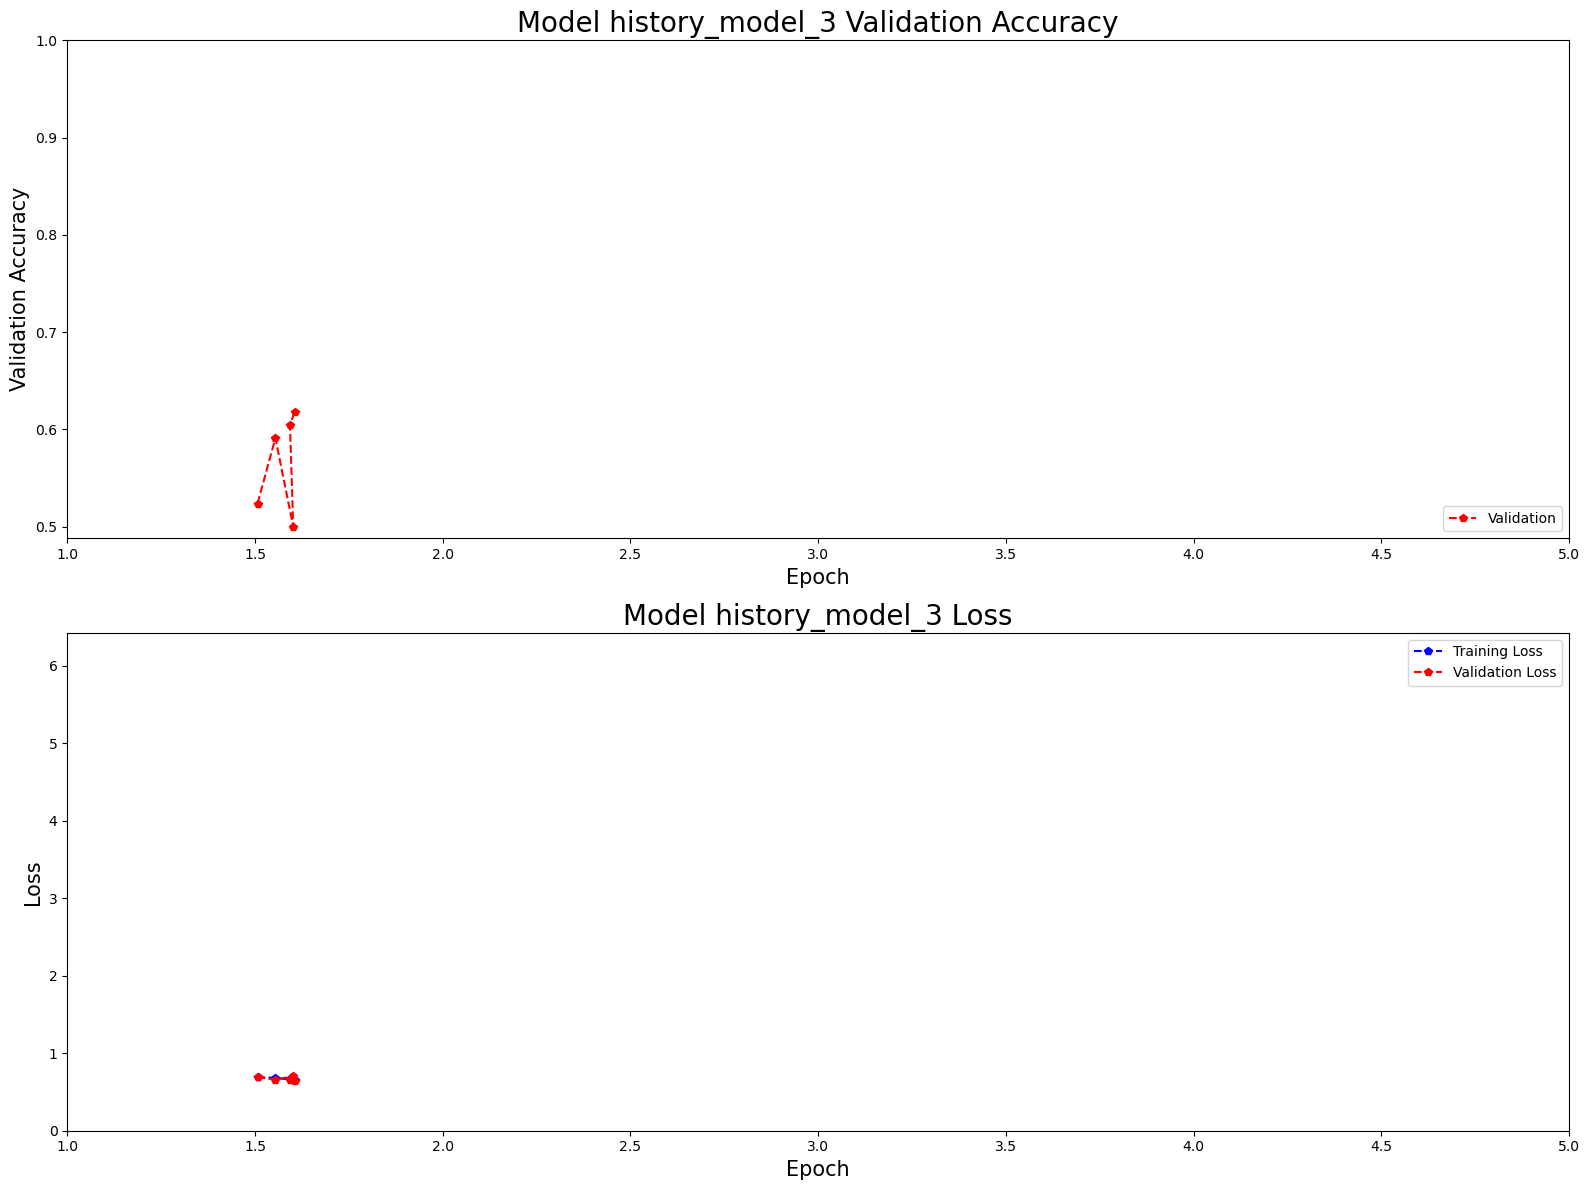

Loading history for model: history_model_4


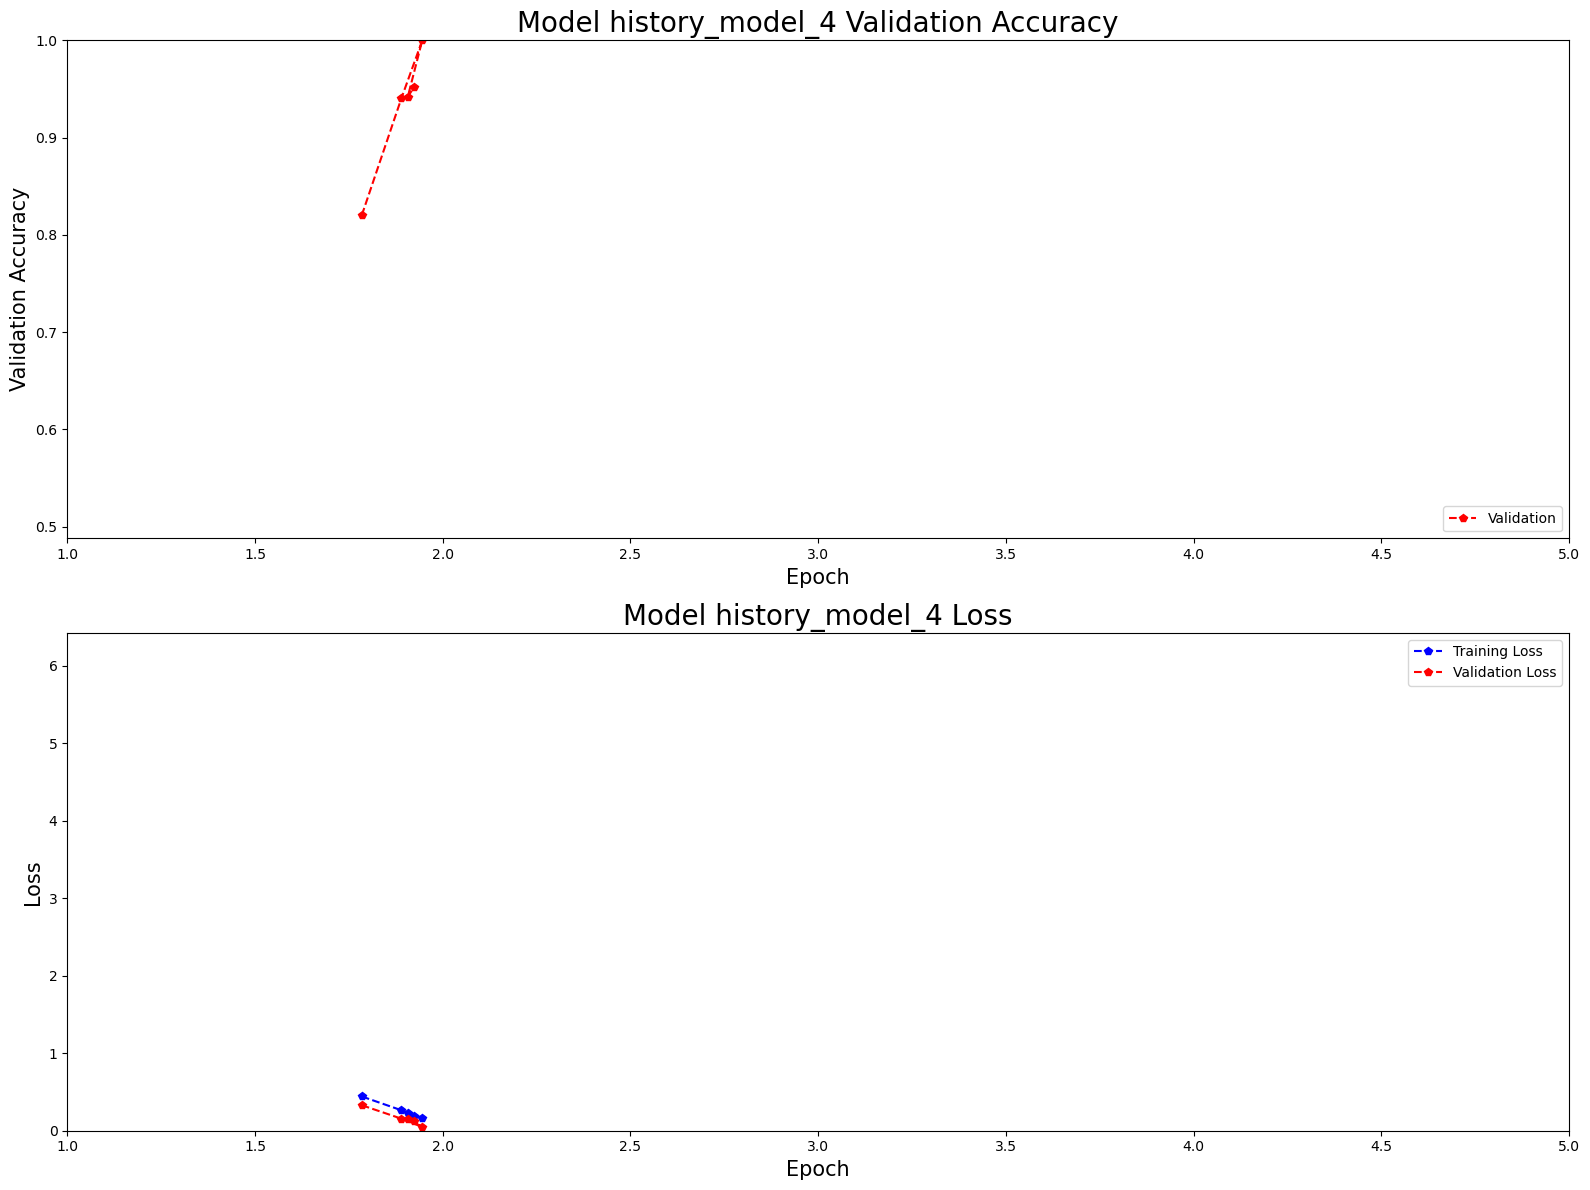

Loading history for model: history_model_5


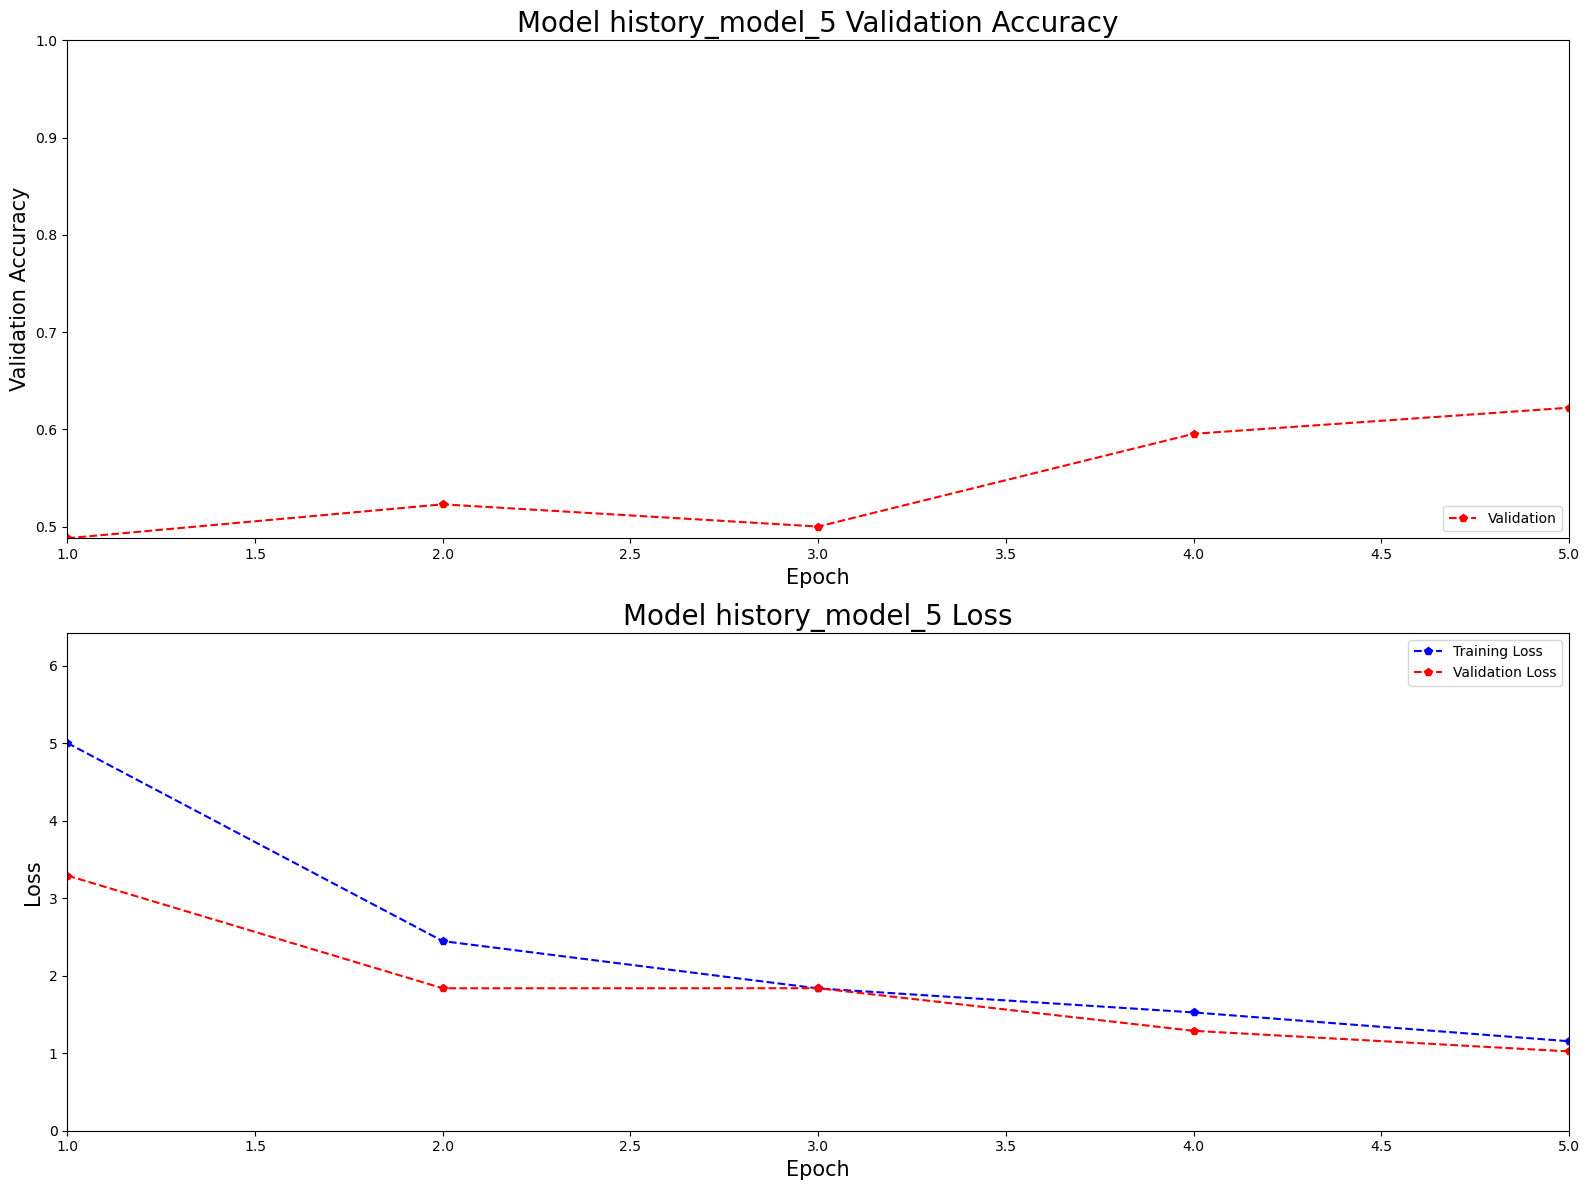

Loading history for model: history_model_6


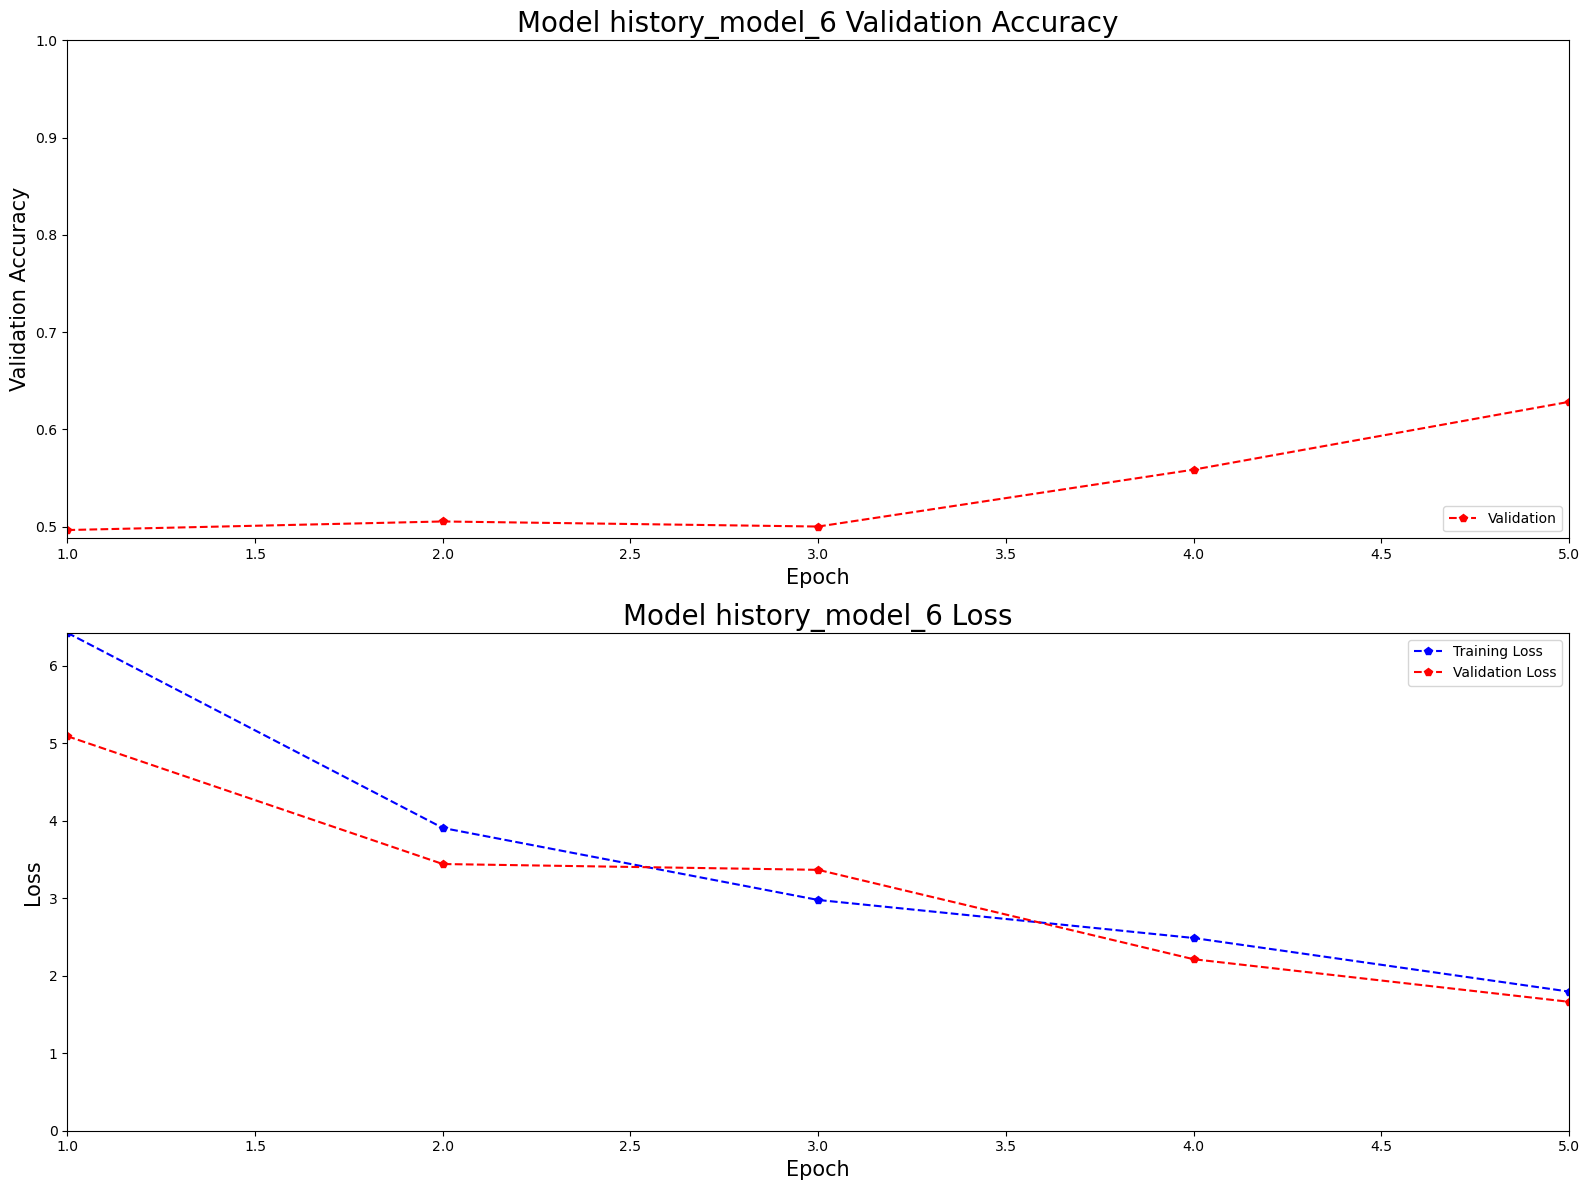

Loading history for model: history_model_7


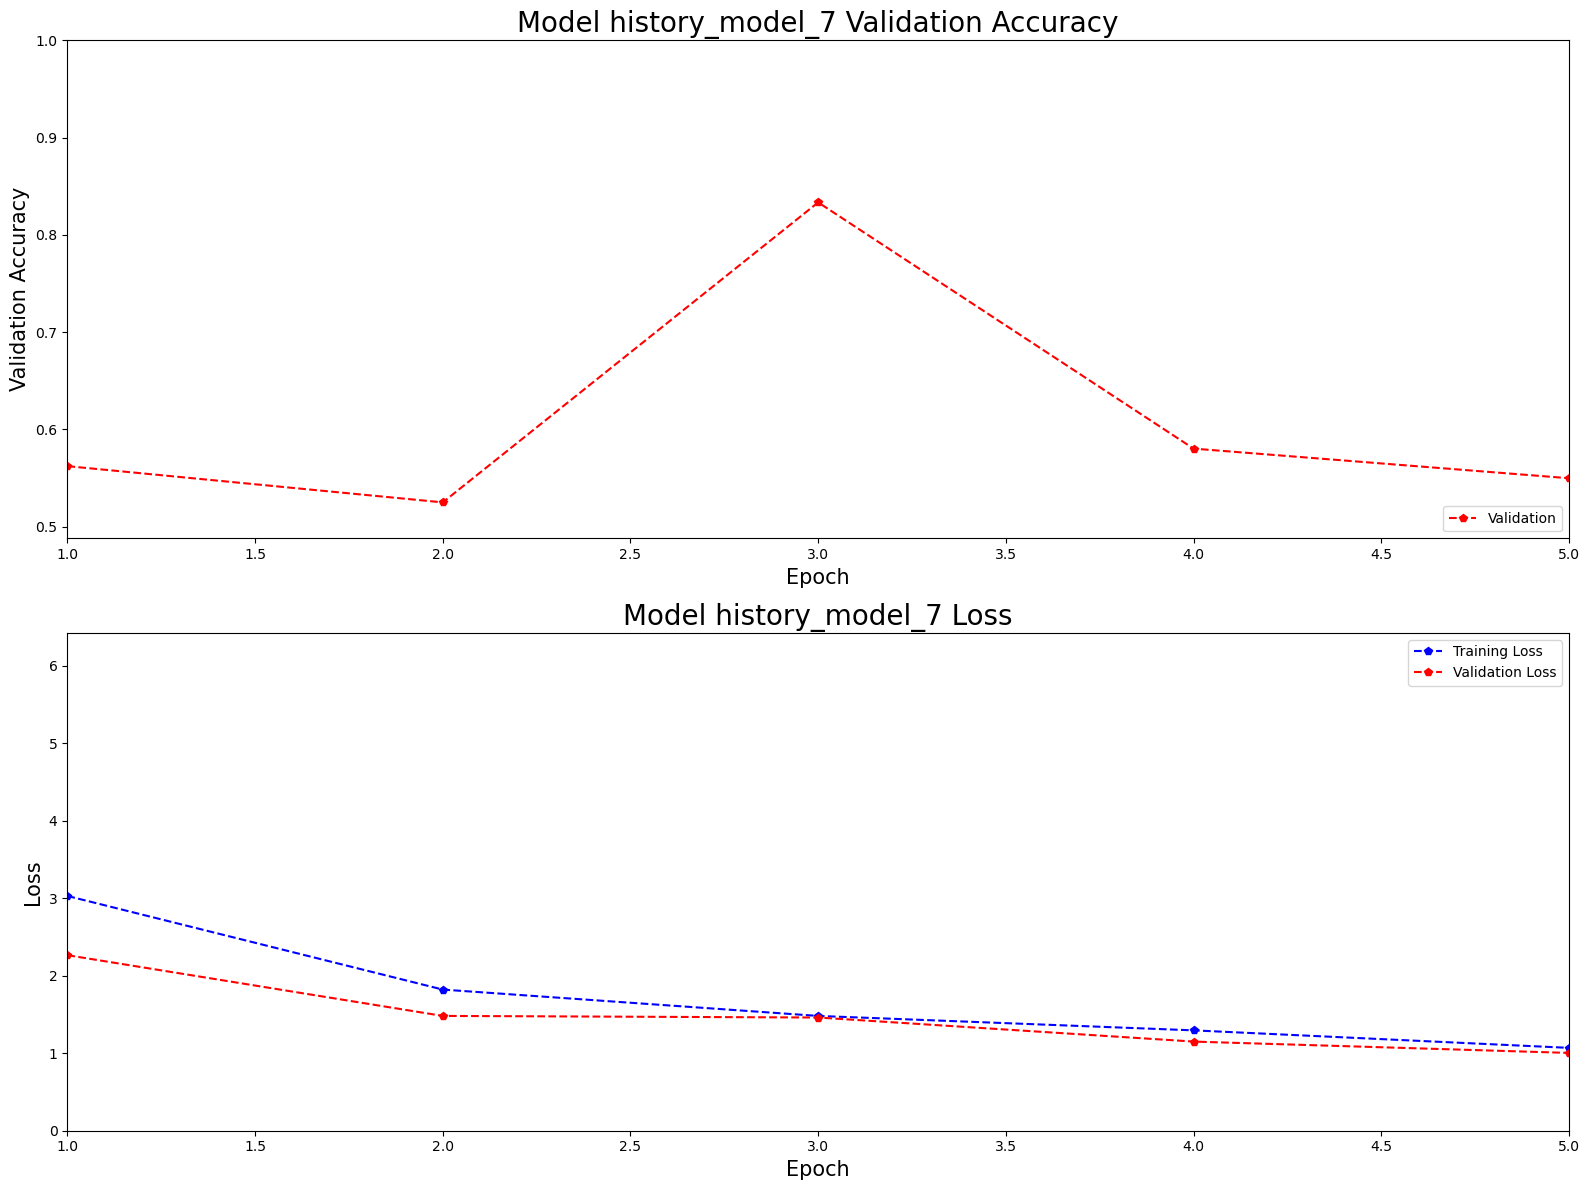

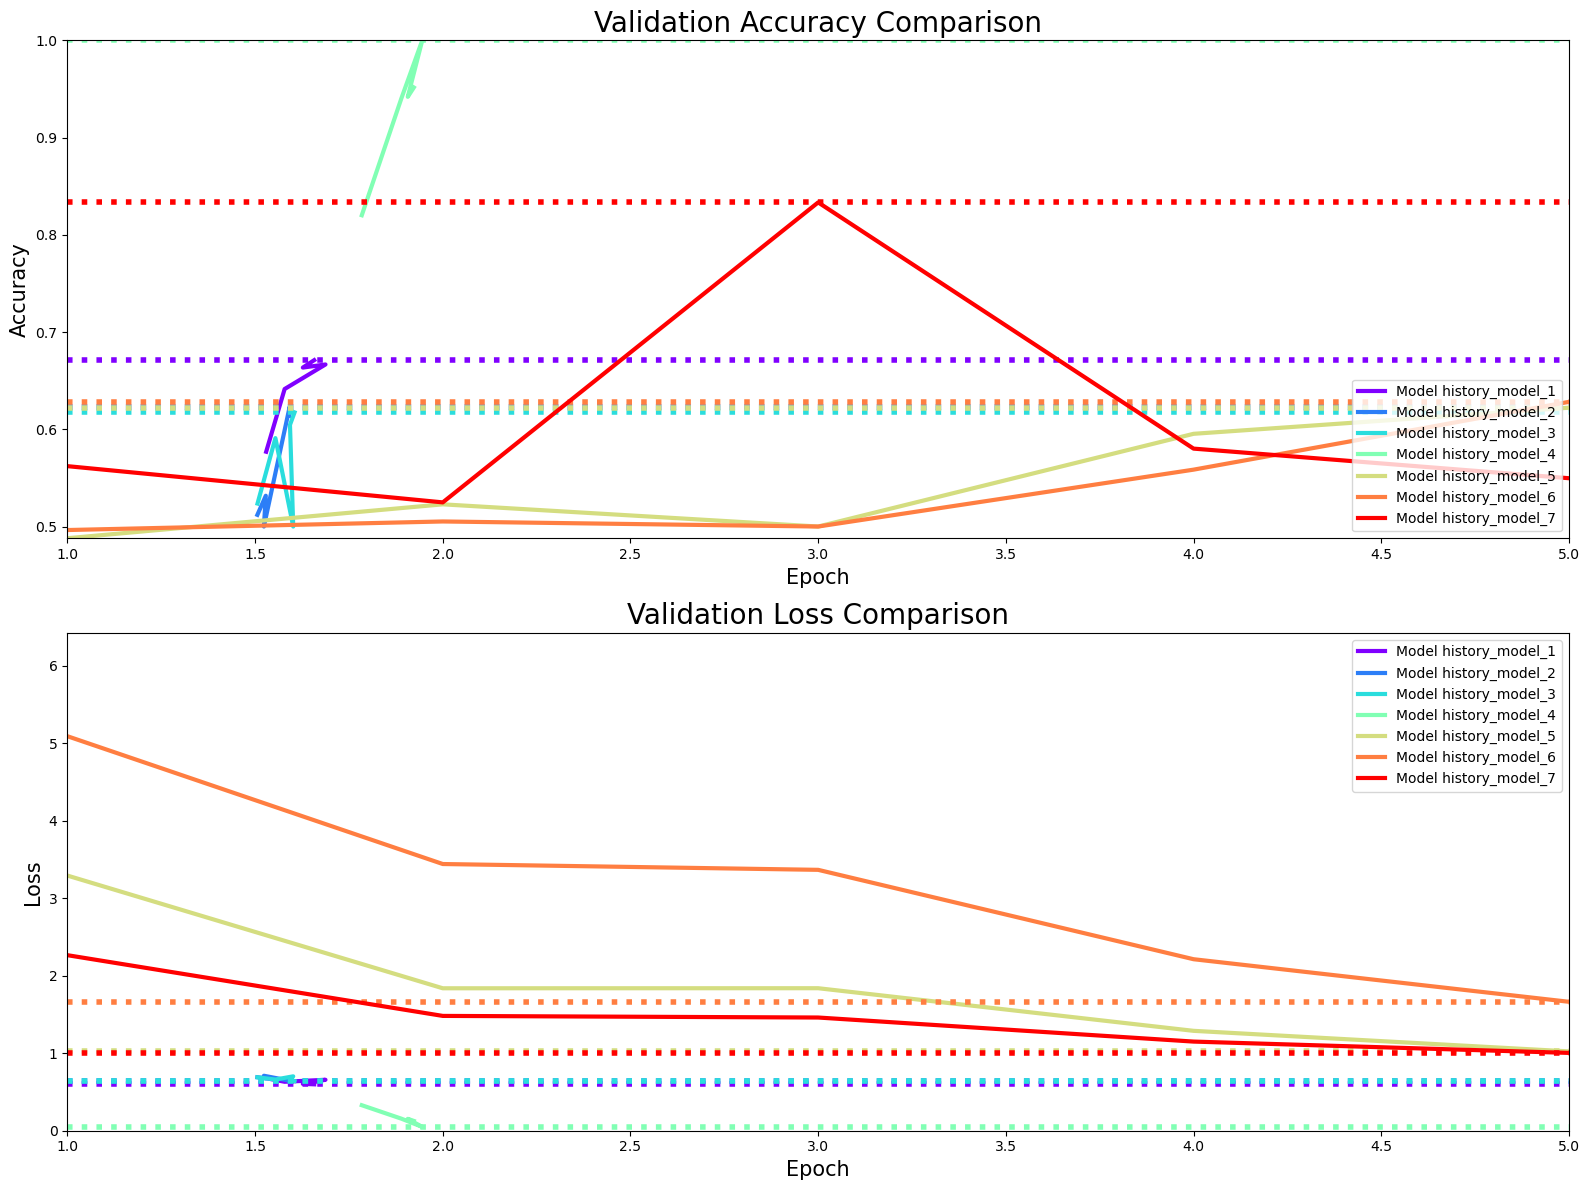

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Updated model names including history_model_5, history_model_6, and history_model_7
model_names = [
    'history_model_1', 
    'history_model_2', 
    'history_model_3', 
    'history_model_4', 
    'history_model_5', 
    'history_model_6', 
    'history_model_7'
]

# Initialize variables
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(model_names)))

# Create charts directory if it doesn't exist
if not os.path.exists('charts'):
    os.makedirs('charts')

# Iterate through models and compute min and max values for accuracy and loss
for model_name in model_names:
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    # Update max index and min/max for loss/accuracy based on available columns
    if 'val_accuracy' in df.columns:
        max_index = max(max_index, max(df.index))
        min_accuracy = min(min_accuracy, df['val_accuracy'].min())
    if 'loss' in df.columns and 'val_loss' in df.columns:
        max_loss = max(max_loss, df[['loss', 'val_loss']].max().max())

# Plot the results for each model
for model_name in model_names:
    print(f'Loading history for model: {model_name}')
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(211)

    # Only plot validation accuracy if it exists
    if 'val_accuracy' in df.columns:
        ax.plot(df['val_accuracy'], "rp--")
        ax.set_title(f'Model {model_name} Validation Accuracy', fontsize=20)
        ax.set_ylabel('Validation Accuracy', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([min_accuracy, 1])

    plt.legend(['Validation'], loc='lower right')

    ax = fig.add_subplot(212)

    # Plot loss if available
    if 'loss' in df.columns and 'val_loss' in df.columns:
        ax.plot(df['loss'], "bp--")
        ax.plot(df['val_loss'], "rp--")
        ax.set_title(f'Model {model_name} Loss', fontsize=20)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([0, max_loss])
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    else:
        print(f"Loss columns not found for {model_name}")

    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model_name}.png', transparent=True, dpi=600)
    plt.show()

# Plot all models' validation accuracy and loss together
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(211)

for model_name, color in zip(model_names, colors):
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    # Plot validation accuracy if available
    if 'val_accuracy' in df.columns:
        ax.plot(df['val_accuracy'], label=f'Model {model_name}', color=color, linewidth=3)
        ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Validation Accuracy Comparison', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
plt.legend(loc='lower right')

ax = fig.add_subplot(212)
for model_name, color in zip(model_names, colors):
    df = pd.read_csv(f'C:/Kodilla/history/{model_name}.csv', index_col=0)
    df.index += 1
    
    # Plot validation loss if available
    if 'val_loss' in df.columns:
        ax.plot(df['val_loss'], label=f'Model {model_name}', color=color, linewidth=3)
        ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Validation Loss Comparison', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()
